# Enrichment analysis of CNVs in schizophrenia

## Introduction
1. Read CNV.bed into four DataFrames.
2. 
3. 
4. 
5. 

The website for seaborn is available at [http://seaborn.pydata.org/examples/horizontal_barplot.html](http://seaborn.pydata.org/examples/horizontal_barplot.html).

Use "%matplotlib inline" for the plot to be showed in Jupyter notebook, instead of saved in other folder.

Use fast Fisher's Exact test at [https://pypi.python.org/pypi/fisher/](https://pypi.python.org/pypi/fisher/).

Use pandas and pandasql to transfer dictionary to DataFrame and to query pandas DataFrames using SQL syntax.

In [7]:
import pandas as pd
from pandasql import sqldf
from fisher import pvalue
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

CNV bed includes four separate datasets, deletion cases, deletion controls, duplication cases and duplication controls. The sample sizes for the four datasets are 1374, 1278, 2228 and 1873, respectively. Every line in each dataset represents a CNV (chromosome, start and end position). Similar start and end positions exit. Some of them are only different by hundreds to thousands of SNPs.

Import CNV.bed file first, divide into four datasets. Each dataset includes 22 chromosome and CNV start/end positions on each chromosome. Then, sort start/end position by ascending order. The CNV.bed file does not include sex chromosome.

In [14]:
filename = "ISC-r1.CNV.bed"
cnvbed = {}
dataset = None
for line in open(filename).readlines():
    if not line.startswith("chr"):
        dataset = line.strip().split()[1].lstrip("name=")
        cnvbed[dataset] = {}
        continue
    line = line.strip().split()
    if not line[0] in cnvbed[dataset]:
        cnvbed[dataset][line[0]] = []
    cnvbed[dataset][line[0]].append((int(line[1]),int(line[2])))
    
for dataset in cnvbed.keys():
    for chrom in cnvbed[dataset]:
        cnvbed[dataset][chrom].sort()

Use pandas to transfer dictionaries from last step to a DataFrame, which contains four parts, cases and controls for deletion and duplication, then drop cuplicates if CNVs share identical chromosome, start and end position.

In [15]:
cnvbed_df = {}
for dataset in cnvbed.keys():
    cnvbed_df[dataset] = {"chrom":[], "cnv_start":[], "cnv_end":[]}
    for chrom in cnvbed[dataset]:
        start, end = tuple(zip(*cnvbed[dataset][chrom]))
        cnvbed_df[dataset]["chrom"].extend([chrom] * len(start))
        cnvbed_df[dataset]["cnv_start"] += list(start)
        cnvbed_df[dataset]["cnv_end"] += list(end)
    cnvbed_df[dataset] = pd.DataFrame.from_dict(cnvbed_df[dataset]).drop_duplicates(
                                            subset=("chrom", "cnv_start", "cnv_end"))

Import reference transcripts and their chromosome, start and end position as a table using pandas.

Use sqldf to query DataFrame. Combine gene by dropping duplicates if they share identical chromosome, start and end position.

In [19]:
ref_gene = pd.read_table("refGene.txt.gz", compression="gzip", sep="\t", header = None, usecols=(1,2,4,5,12), 
                            names = ["tx_name", "chrom", "tx_start", "tx_end", "gene_name"])
query = """
SELECT gene_name, chrom, tx_start, tx_end 
FROM ref_gene 
GROUP by chrom, gene_name
"""
gene_df = sqldf(query).drop_duplicates(subset=("chrom", "tx_start", "tx_end"))
gene_df = gene_df.rename(columns={"tx_start": "gene_start", "tx_end": "gene_end"})
#print (gene_df)

Figure out how many CNVs in each gene according to their start/end position.
1. If the start and/or end postion for a CNV locate between a gene, it is said that CNV and gene overlap. Each line represents a CNV. However, same CNV may overlap with more than one gene, and one gene may contain more than one CNV.

|   |  chr |  start |  end |  gene |
|---|---|---|---|---|
|1|     chr11|    1774671 |   1945240 |         CTSD|
|2|     chr11|    1774671 |   1945240 |        TNNT3|
|3|     chr11|    4077830 |   4264576 |        STIM1|
|4|     chr11|    4077830 |   4303386 |        STIM1|
|5|     chr11|    4081373 |   4232710 |        STIM1|
|6|     chr11|    4081373 |   4302348 |        STIM1|

2.

In [20]:
cnv_in_gene = {}
cnv_counts = {}
for name, value in cnvbed_df.items():
    query = """
    SELECT cnv.chrom, cnv.cnv_start, cnv.cnv_end, gene.gene_name
    FROM value cnv LEFT JOIN gene_df gene
    WHERE cnv.chrom == gene.chrom 
    AND (
    (cnv.cnv_start >= gene.gene_start AND cnv.cnv_start <= gene.gene_end)
    OR
    (cnv.cnv_end >= gene.gene_start AND cnv.cnv_end <= gene.gene_end)
    )
    """
    cnv_in_gene[name] = value = sqldf(query)
    query = """
    SELECT chrom, gene_name, count(gene_name), cnv_start, cnv_end
    FROM value
    GROUP BY gene_name, chrom
    ORDER BY count(gene_name) DESC
    """
    cnv_counts[name] = sqldf(query)
print (cnv_in_gene)
#print (cnv_counts["delCases"], cnv_counts["delControls"])
#print (sum(cnv_counts["delCases"]["count(gene_name)"]), sum(cnv_counts["delControls"]["count(gene_name)"]))

{'dupCases':       chrom  cnv_start    cnv_end     gene_name
0     chr11     976837    1242753         AP2A2
1     chr11    1774671    1945240          CTSD
2     chr11    1774671    1945240         TNNT3
3     chr11    4077830    4264576         STIM1
4     chr11    4077830    4303386         STIM1
5     chr11    4081373    4232710         STIM1
6     chr11    4081373    4302348         STIM1
7     chr11    4085062    4219150  LOC100506082
8     chr11    4085062    4219150         STIM1
9     chr11    6580678    6965053         DNHD1
10    chr11    6580678    6965053        ZNF215
11    chr11    7509464    7770296        OLFML1
12    chr11   31312028   31554033         DCDC1
13    chr11   31312028   31554033          ELP4
14    chr11   32915185   33045142        DEPDC7
15    chr11   32915185   33045142         QSER1
16    chr11   40577791   41168679        LRRC4C
17    chr11   48042727   48517281         PTPRJ
18    chr11   49696718   49979611     LOC440040
19    chr11   50050685   50

In [30]:
query = """
select gene_name, chrom, tx_start, tx_end
from ref_gene 
where gene_name = "LOC101928381"
"""
print (sqldf(query))

query = """
select gene_name, chrom, tx_start, tx_end
from ref_gene 
where gene_name = "FAM72C"
"""
print (sqldf(query))

      gene_name chrom  tx_start    tx_end
0  LOC101928381  chr9  42771707  42782614
1  LOC101928381  chr9  66922966  66933829
2  LOC101928381  chr9  69746916  69757784
3  LOC101928381  chr9  70364017  70374924
  gene_name chrom   tx_start     tx_end
0    FAM72C  chr1  143896524  143913160
1    FAM72C  chr1  206138439  206155074
2    FAM72C  chr1  143896524  143913160
3    FAM72C  chr1  143896524  143913160
4    FAM72C  chr1  143896524  143914673
5    FAM72C  chr1  143896524  143914673
6    FAM72C  chr1  143904508  143913160


In [31]:
delCases = cnv_counts["delCases"]
delControls = cnv_counts["delControls"]
del_table = pd.merge(delCases, delControls, how = "outer", on = ["chrom", "gene_name"])
del_table["count(gene_name)_x"].fillna(0, inplace=True)
del_table["count(gene_name)_y"].fillna(0, inplace=True)
n_delCases = sum(cnv_counts["delCases"]["count(gene_name)"])
n_delCtrls = sum(cnv_counts["delControls"]["count(gene_name)"])
del_table = del_table.rename(columns={"count(gene_name)_x": "n_delcase_gene", 
                                      "count(gene_name)_y": "n_delctrl_gene"})
del_table["n_delcase_nogene"] = n_delCases - del_table["n_delcase_gene"]
del_table["n_delctrl_nogene"] = n_delCtrls - del_table["n_delctrl_gene"]
del_table = del_table[["gene_name", "n_delcase_gene", "n_delctrl_gene", "n_delcase_nogene", "n_delctrl_nogene"]]

In [32]:
dupCases = cnv_counts["dupCases"]
dupControls = cnv_counts["dupControls"]
dup_table = pd.merge(dupCases, dupControls, how = "outer", on = ["chrom", "gene_name"])
dup_table["count(gene_name)_x"].fillna(0, inplace=True)
dup_table["count(gene_name)_y"].fillna(0, inplace=True)
n_dupCases = sum(cnv_counts["dupCases"]["count(gene_name)"])
n_dupCtrls = sum(cnv_counts["dupControls"]["count(gene_name)"])
dup_table = dup_table.rename(columns={"count(gene_name)_x": "n_dupcase_gene", 
                                      "count(gene_name)_y": "n_dupctrl_gene"})
dup_table["n_dupcase_nogene"] = n_dupCases - dup_table["n_dupcase_gene"]
dup_table["n_dupctrl_nogene"] = n_dupCtrls - dup_table["n_dupctrl_gene"]
dup_table = dup_table[["gene_name", "n_dupcase_gene", "n_dupctrl_gene", "n_dupcase_nogene", "n_dupctrl_nogene"]]

In [33]:
p_2side_del = []
p_rside_del = []
gene_list_del = []
logp_2side_del = []
logp_rside_del = []
for index, row in del_table.iterrows():
    p_del = pvalue(row["n_delcase_gene"], row["n_delctrl_gene"], row["n_delcase_nogene"], row["n_delctrl_nogene"])
    p_2side_del.append(p_del.two_tail)
    logp_2side_del.append(-np.log10(p_del.two_tail))
    p_rside_del.append(p_del.right_tail)
    logp_rside_del.append(-np.log10(p_del.right_tail))
    gene_list_del.append(row["gene_name"])

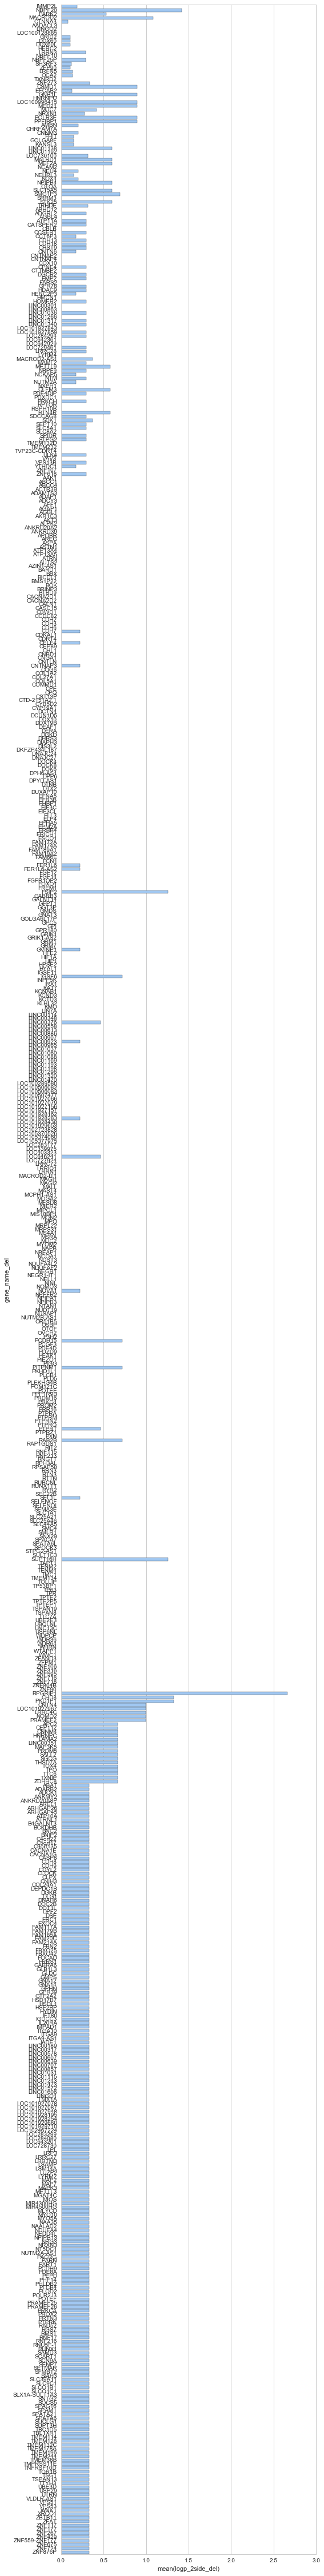

In [34]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 80))
p_df_del = pd.DataFrame({"logp_2side_del": logp_2side_del, "logp_rside_del": logp_rside_del, 
                         "gene_name_del": gene_list_del})
plot_del = sns.barplot(x="logp_2side_del", y="gene_name_del", data=p_df_del, label="log pvalue 2-sided", color="b")

In [35]:
p_2side_dup = []
p_rside_dup = []
gene_list_dup = []
logp_2side_dup = []
logp_rside_dup = []
for index, row in dup_table.iterrows():
    p_dup = pvalue(row["n_dupcase_gene"], row["n_dupctrl_gene"], row["n_dupcase_nogene"], row["n_dupctrl_nogene"])
    p_2side_dup.append(p_dup.two_tail)
    logp_2side_dup.append(-np.log10(p_dup.two_tail))
    p_rside_dup.append(p_dup.right_tail)
    logp_rside_dup.append(-np.log10(p_dup.right_tail))
    gene_list_dup.append(row["gene_name"])

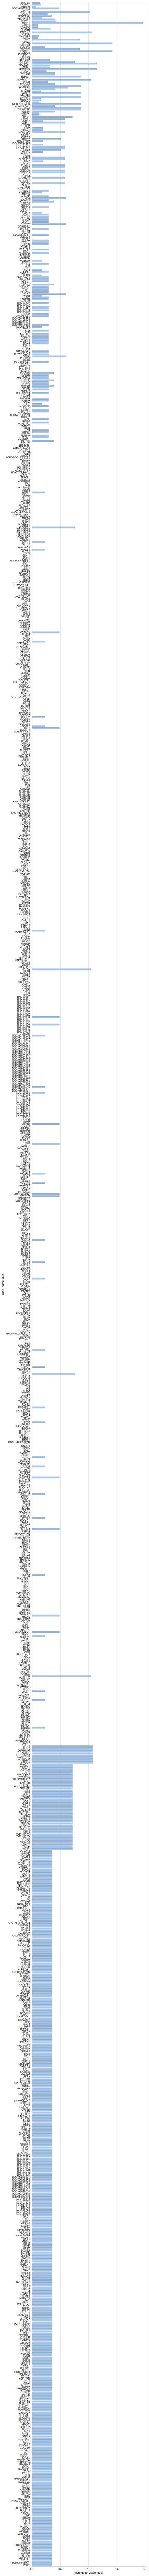

In [23]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 180))
p_df_dup = pd.DataFrame({"logp_2side_dup": logp_2side_dup, "logp_rside_dup": logp_rside_dup, 
                         "gene_name_dup": gene_list_dup})
plot_dup = sns.barplot(x="logp_2side_dup", y="gene_name_dup", data=p_df_dup, label="log pvalue 2-sided", color="b")